### This notebook contains various calculations mentioned in the paper

In [4]:
# Importing relevant packages
import numpy as np
import pandas as pd
import os, sys
import pickle
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from scipy.stats import ttest_1samp, ttest_rel


from collections import Counter
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.linear_model import LinearRegression
import seaborn as sns
from scipy import stats as stats


# %matplotlib inline

# %load_ext autoreload
# %autoreload 2

## path to the downloaded gutenberg corpus
path_gutenberg = os.path.join(os.pardir,os.pardir,'gutenberg')

## import internal helper functions
src_dir = os.path.join(os.pardir,'src')
sys.path.append(src_dir)
from data_io import get_book

import re
import random

# Accessing the metadata
sys.path.append(os.path.join(path_gutenberg,'src'))
from metaquery import meta_query
mq = meta_query(path=os.path.join(path_gutenberg,'metadata','metadata.csv'), filter_exist=False)

from itertools import combinations
from data_io import get_book, get_p12_same_support
from metric_eval import prob_x_less_than_y_freq_new, prob_x_less_than_y_emb_new
from jsd import jsdalpha

### Identifying optimal values of alpha

In [6]:
def create_avg_se_dict(weights = False):
    if weights:
        string = '_weights'
    else:
        string = ''

    dataframe_dict = {}
    dataframe_dict_controlled = {}

    task_numbers = [i for i in range(11,21)]
    alphas = [i/20 for i in range(41)]
    col_names = [str(i) for i in alphas]

    for task in ['author', 'subject', 'time']:
        dataframe_list = []
        dataframe_list_controlled = []

        for num in task_numbers:
            input_file_path_opt_alpha_controlled = f'../output_files/optimal_alpha{string}_new_controlled_{task}{num}.pickle'
            with open(input_file_path_opt_alpha_controlled, 'rb') as f:
                opt_alpha_results_controlled = pickle.load(f)

            input_file_path_opt_alpha = f'../output_files/optimal_alpha{string}_new_{task}{num}.pickle'
            with open(input_file_path_opt_alpha, 'rb') as f:
                opt_alpha_results = pickle.load(f)
            
            dataframe_list.append(opt_alpha_results.copy())
            dataframe_list_controlled.append(opt_alpha_results_controlled.copy())
        
        df = pd.DataFrame(dataframe_list, columns=col_names)
        df_controlled = pd.DataFrame(dataframe_list_controlled, columns=col_names)

        alpha_avgs = []
        alpha_stds = []

        alpha_avgs_controlled = []
        alpha_stds_controlled = []

        for alpha in col_names:
            current = df[alpha].to_numpy()
            alpha_avgs.append(np.mean(current))
            alpha_stds.append(np.std(current))

            current_controlled = df_controlled[alpha].to_numpy()
            alpha_avgs_controlled.append(np.mean(current_controlled))
            alpha_stds_controlled.append(np.std(current_controlled))
        
        dataframe_dict[task] = (tuple(alpha_avgs), tuple(alpha_stds))
        dataframe_dict_controlled[task] = (tuple(alpha_avgs_controlled), tuple(alpha_stds_controlled))
    
    return dataframe_dict_controlled, dataframe_dict

In [7]:
print("Uncontrolled corpora")
dataframe_dict_controlled, dataframe_dict = create_avg_se_dict()
alphas = [i/20 for i in range(41)]
task_numbers = [i for i in range(11,21)]
for task in ['author', 'subject', 'time']:
    vals = dataframe_dict[task][0]
    index = vals.index(max(vals))
    print(f'{task}: P(X<Y) = {vals[index]}, alpha = {alphas[index]}')


print("\nControlled corpora")
for task in ['author', 'subject', 'time']:
    vals = dataframe_dict_controlled[task][0]
    # index = alphas.index(1.0)
    index = vals.index(max(vals))
    print(f'{task}: P(X<Y) = {vals[index]}, alpha = {alphas[index]}')


Uncontrolled corpora
author: P(X<Y) = 0.8742726, alpha = 0.65
subject: P(X<Y) = 0.6749185, alpha = 0.6
time: P(X<Y) = 0.5712482000000001, alpha = 0.8

Controlled corpora
author: P(X<Y) = 0.8960076000000001, alpha = 0.7
subject: P(X<Y) = 0.6542960000000001, alpha = 0.6
time: P(X<Y) = 0.6734418000000001, alpha = 0.6


### Number of texts in our filtered corpus

In [8]:
# Perform necessary filtering
mq.reset()
mq.filter_lang('en',how='only')
# Only select books with more than 20 downloads
df = mq.get_df()
mq.df = df[df['downloads'] >= 20]
# 1800 onwards
mq.filter_year([1800, 2050])
# Filter out data with no subject listed
df = mq.get_df()
mq.df = df[df['subjects'] != 'set()']
# Filter out entries that don't have author birth or death year
df = mq.get_df()
mq.df = df[df[['authoryearofbirth', 'authoryearofdeath']].notnull().all(1)]

all_uniq_ids = mq.get_ids()
print(len(all_uniq_ids))

13923


### Summary table of results

In [9]:
# Comparing results
# Columns: alpha=1, optimal alpha, jaccard, angular, manhattan, euclidean
dataframe_dict = {'tasks' : ['author']*10 + ['subject']*10 + ['time period']*10 }
model_name = 'all-MiniLM-L6-v2'
suffix = 'new_controlled'

# Extracting the alpba=1 and optimal alpha column
alpha1 = []
alpha_opt = []
# alpha1_weights = []
# alpha_opt_weights = []

for task in ['author', 'subject', 'time']:
    task_numbers = [i for i in range(11,21)]

    for num in task_numbers:
        input_file_path_opt_alpha = f'../output_files/optimal_alpha_{suffix}_{task}{num}.pickle'
        with open(input_file_path_opt_alpha, 'rb') as f:
            opt_alpha_results = pickle.load(f)
        
        # input_file_path_opt_alpha_weights = f'../output_files/optimal_alpha_weights_{task}{num}.pickle'
        # with open(input_file_path_opt_alpha_weights, 'rb') as f:
        #     opt_alpha_results_weights = pickle.load(f)
        
        alpha1.append(round(opt_alpha_results[20],2))
        alpha_opt.append(round(max(opt_alpha_results),2))
        # alpha1_weights.append(round(opt_alpha_results_weights[20],2))
        # alpha_opt.append(round(max(opt_alpha_results_weights),2))

dataframe_dict['alpha=1'] = alpha1
dataframe_dict['best alpha'] = alpha_opt
# dataframe_dict['alpha=1 (weights)'] = alpha1_weights
# dataframe_dict['best alpha (weights)'] = alpha_opt_weights


# Frequency results 
for name in ['jaccard', 'euclidean_freq']:
    input_file_path_current = f'../output_files/{name}_results_new.pickle'
    with open(input_file_path_current, 'rb') as f:
        results_dict = pickle.load(f)
    all_results = []
    current_results = results_dict[suffix]
    for key in current_results:
        all_results += [round(i,2) for i in current_results[key]]
    dataframe_dict[name] = all_results


# Extracting the columns from embeddings
for name in ['angular', 'manhattan', 'euclidean', 'euclidean_normed', 'jsd']:
    input_file_path_current = f'../output_files/{name}_embedding_results_new.pickle'
    with open(input_file_path_current, 'rb') as f:
        results_dict = pickle.load(f)
    all_results = []
    current_results = results_dict[suffix]
    for key in current_results:
        all_results += [round(i,2) for i in current_results[key]]
    dataframe_dict[name] = all_results


# Displaying as a dataframe
df = pd.DataFrame(dataframe_dict)
df

,tasks,alpha=1,best alpha,jaccard,euclidean_freq,angular,manhattan,euclidean,euclidean_normed,jsd
0,author,0.66,0.75,0.70,0.66,0.66,0.63,0.63,0.66,0.39
1,author,0.90,0.92,0.86,0.89,0.86,0.85,0.85,0.86,0.21
2,author,0.91,0.92,0.91,0.77,0.68,0.66,0.66,0.68,0.35
3,author,0.92,0.94,0.89,0.91,0.85,0.85,0.85,0.85,0.17
4,author,0.87,0.92,0.87,0.78,0.78,0.79,0.78,0.78,0.23
5,author,0.86,0.90,0.85,0.81,0.82,0.80,0.80,0.82,0.18
6,author,0.90,0.90,0.89,0.85,0.81,0.78,0.78,0.81,0.22
7,author,0.98,0.98,0.94,0.97,0.92,0.92,0.92,0.92,0.26
8,author,0.89,0.91,0.88,0.86,0.82,0.81,0.81,0.82,0.18
9,author,0.93,0.94,0.89,0.88,0.81,0.79,0.79,0.81,0.17


### Summary table of results (with average and SD)

In [10]:
# Similar to above, but with average values and standard errors
# Comparing results
# Columns: alpha=1, optimal alpha, jaccard, angular, manhattan, euclidean
dataframe_dict = {'tasks':['author', 'subject', 'time period']}
model_name = 'all-MiniLM-L6-v2'
suffix = 'new'
# suffix = 'new'

# Extracting the alpba=1 and optimal alpha column
alpha1 = []
alpha_opt = []
# alpha1_weights = []
# alpha_opt_weights = []
optimal_alphas = {'author':0.65, 'subject':0.6, 'time':0.8}
opt_alpha_indexes = {'author':13, 'subject':12, 'time':16}

for task in ['author', 'subject', 'time']:
    task_numbers = [i for i in range(11,21)]
    opt_alpha_index = opt_alpha_indexes[task]

    current_alpha1 = []
    current_alpha_opt = []
    # current_alpha1_weights = []
    # current_alpha_opt_weights = []

    for num in task_numbers:
        input_file_path_opt_alpha = f'../output_files/optimal_alpha_{suffix}_{task}{num}.pickle'
        with open(input_file_path_opt_alpha, 'rb') as f:
            opt_alpha_results = pickle.load(f)
        
        # input_file_path_opt_alpha_weights = f'../output_files/optimal_alpha_weights_{task}{num}.pickle'
        # with open(input_file_path_opt_alpha_weights, 'rb') as f:
        #     opt_alpha_results_weights = pickle.load(f)

        current_alpha1.append(opt_alpha_results[20])
        current_alpha_opt.append(opt_alpha_results[opt_alpha_index])
        # current_alpha1_weights.append(opt_alpha_results_weights[20])
        # current_alpha_opt.append(max(opt_alpha_results_weights))
    
    alpha1.append(f'{round(np.mean(np.array(current_alpha1)), 4)}' + 
                    ' \u00B1 ' + f'{round(np.std(np.array(current_alpha1))/np.sqrt(10), 4)}')
    alpha_opt.append(f'{round(np.mean(np.array(current_alpha_opt)), 4)}' + 
                    ' \u00B1 ' + f'{round(np.std(np.array(current_alpha_opt))/np.sqrt(10), 4)}')
    # alpha1_weights.append(f'{round(np.mean(np.array(alpha1_weights)), 2)}' + ' \u00B1 ' + f'{round(np.std(np.array(alpha1_weights)), 2)}')
    # alpha_opt_weights = f'{round(np.mean(np.array(alpha_opt_weights)), 2)}' + ' \u00B1 ' + f'{round(np.std(np.array(alpha_opt_weights)), 2)}'

dataframe_dict['alpha=1'] = alpha1
dataframe_dict['best alpha'] = alpha_opt
# dataframe_dict['alpha=1 (weights)'] = alpha1_weights
# dataframe_dict['best alpha (weights)'] = alpha_opt_weights



# Frequency results 
for name in ['jaccard', 'overlap', 'euclidean_freq', 'text_length']:
    input_file_path_current = f'../output_files/{name}_results_new.pickle'
    with open(input_file_path_current, 'rb') as f:
        results_dict = pickle.load(f)
    all_results = []
    current_results = results_dict[suffix]
    for key in current_results:
        all_results.append(f'{round(np.mean(np.array(current_results[key])), 4)}' + 
                            ' \u00B1 ' + f'{round(np.std(np.array(current_results[key]))/np.sqrt(10), 4)}')
    dataframe_dict[name] = all_results


# Extracting the columns from embeddings
for name in ['angular', 'manhattan', 'euclidean', 'euclidean_normed', 'jsd']:
    input_file_path_current = f'../output_files/{name}_embedding_results_new.pickle'
    with open(input_file_path_current, 'rb') as f:
        results_dict = pickle.load(f)
    all_results = []
    current_results = results_dict[suffix]
    for key in current_results:
        all_results.append(f'{round(np.mean(np.array(current_results[key])), 4)}' + 
                            ' \u00B1 ' + f'{round(np.std(np.array(current_results[key]))/np.sqrt(10), 4)}')
    dataframe_dict[name] = all_results

# Displaying as a dataframe
df = pd.DataFrame(dataframe_dict)
df

,tasks,alpha=1,best alpha,jaccard,overlap,euclidean_freq,text_length,angular,manhattan,euclidean,euclidean_normed,jsd
0,author,0.8288 ± 0.0035,0.8743 ± 0.0038,0.7959 ± 0.0041,0.6701 ± 0.0022,0.8133 ± 0.0025,0.6533 ± 0.0041,0.8599 ± 0.0025,0.8447 ± 0.0026,0.8448 ± 0.0026,0.8599 ± 0.0025,0.1741 ± 0.0017
1,subject,0.6408 ± 0.0038,0.6749 ± 0.0048,0.6326 ± 0.0041,0.5043 ± 0.0039,0.6403 ± 0.0056,0.5956 ± 0.0042,0.6966 ± 0.004,0.6846 ± 0.0043,0.6847 ± 0.0042,0.6966 ± 0.004,0.3219 ± 0.0027
2,time period,0.5664 ± 0.003,0.5712 ± 0.0026,0.5953 ± 0.0028,0.4782 ± 0.0023,0.5295 ± 0.0033,0.5883 ± 0.0028,0.5293 ± 0.0035,0.5357 ± 0.0034,0.5354 ± 0.0034,0.5293 ± 0.0035,0.4691 ± 0.0028


### Statistical tests

In [11]:
# Comparing against the baseline (0.5)
def compare_to_baseline(task, controlled, measure_name):
    input_file_path_current = f'../output_files/{measure_name}_results_new.pickle'
    with open(input_file_path_current, 'rb') as f:
        results_dict = pickle.load(f)
    all_results = []
    current_results = results_dict[controlled][task]
    return ttest_1samp(current_results, 0.5).pvalue

for task in ['author','subject','time']:
    for controlled in ['new']:
        print(compare_to_baseline(task, controlled, 'text_length'))

5.329676602796183e-11
4.283663682397731e-09
2.731115002236931e-10


In [12]:
# Statistical test between alpha = 1 and optimal alpha
optimal_alphas = {'author':0.65, 'subject':0.6, 'time':0.8}
opt_alpha_indexes = {'author':13, 'subject':12, 'time':16}
suffix = 'new'

for task in ['author', 'subject', 'time']:
    task_numbers = [i for i in range(11,21)]
    opt_alpha_index = opt_alpha_indexes[task]

    current_alpha1 = []
    current_alpha_opt = []

    for num in task_numbers:
        input_file_path_opt_alpha = f'../output_files/optimal_alpha_{suffix}_{task}{num}.pickle'
        with open(input_file_path_opt_alpha, 'rb') as f:
            opt_alpha_results = pickle.load(f)

        current_alpha1.append(opt_alpha_results[20])
        current_alpha_opt.append(opt_alpha_results[opt_alpha_index])
    
    print(task, ttest_rel(current_alpha1, current_alpha_opt).pvalue)

author 1.9005777297816666e-10
subject 1.862259875507202e-05
time 0.0162951376194747


In [13]:
# Tests between optimal JSD and embedding
optimal_alphas = {'author':0.65, 'subject':0.6, 'time':0.8}
opt_alpha_indexes = {'author':13, 'subject':12, 'time':16}
task = 'time'
suffix = 'new'

# Extracting JSD values
task_numbers = [i for i in range(11,21)]
opt_alpha_index = opt_alpha_indexes[task]

current_alpha1 = []
current_alpha_opt = []

for num in task_numbers:
    input_file_path_opt_alpha = f'../output_files/optimal_alpha_{suffix}_{task}{num}.pickle'
    with open(input_file_path_opt_alpha, 'rb') as f:
        opt_alpha_results = pickle.load(f)

    current_alpha1.append(opt_alpha_results[20])
    current_alpha_opt.append(opt_alpha_results[opt_alpha_index])


# Getting embedding value
measure_name = 'angular'
with open(f'../output_files/{measure_name}_embedding_results_new.pickle', 'rb') as f:
    results_dict = pickle.load(f)
emb_results = results_dict[suffix][task]

# Getting Jaccard or overlap value
name = 'jaccard'
input_file_path_current = f'../output_files/{name}_results_new.pickle'
with open(input_file_path_current, 'rb') as f:
    results_dict = pickle.load(f)
vocab_results = results_dict[suffix][task]

# result
print(task, ttest_rel(vocab_results, current_alpha_opt).pvalue)

time 5.3739466512813736e-08


### Variability of text length

In [ ]:
# Output subject counts in descending order
mq.reset()

# Filter by language (English only)
mq.filter_lang('en',how='only')

# Only select books with more than 20 downloads
df = mq.get_df()
mq.df = df[df['downloads'] >= 20]

# 1800 onwards
mq.filter_year([1800, 2050])

# Filter out data with no subject listed
df = mq.get_df()
mq.df = df[df['subjects'] != 'set()']

# Filter out data that is missing author birth and death years
df = mq.get_df()
mq.df = df[df[['authoryearofbirth', 'authoryearofdeath']].notnull().all(1)]

all_ids = mq.get_ids()
text_lengths = []

for id in all_ids:
    try:
        book = get_book(id)
    except:
        continue
    length = sum(book.values())
    text_lengths.append(length)

print(np.mean(np.array(text_lengths)))
print(np.std(np.array(text_lengths)))

### Creating a word frequency plot of all texts

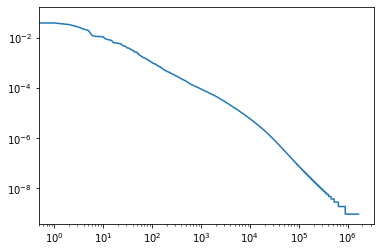

In [16]:
# Create the full vocabulary
all_ids = mq.get_ids()
full_vocab = {}

for id in all_ids:
    try:
        book = get_book(id)
    except:
        continue
    for word in book:
        if word in full_vocab:
            full_vocab[word] += book[word]
        else:
            full_vocab[word] = book[word]

# Store in a pickle file
output_file_path = '../output_files/full_vocab.pickle'

# with open(output_file_path, 'wb') as f:
#     pickle.dump(full_vocab, f)

# Rank-frequency plot of full vocabulary
with open(output_file_path, 'rb') as f:
        full_vocab = pickle.load(f)
counts = []
for word in full_vocab:
    if full_vocab[word] > 0:
        counts.append(full_vocab[word])
counts.sort(reverse=True)
freqs = np.array(counts)/sum(counts)
ranks = [i for i in range(len(counts))]
ranks.sort()

plt.loglog(ranks, freqs)
plt.show()